In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score

In [19]:
# Função para imprimir e salvar matriz de confusão
def imprimeMatrizDeConfusão(y_test, preds, model, salvarFigura = False):
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    import matplotlib.pyplot as plt

    cm = confusion_matrix(y_test, preds, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot(values_format= '.2%', xticks_rotation=60, colorbar=False)
    disp.ax_.set_title("Matriz de confusão normalizada sobre as condições verdadeiras")
    if(salvarFigura):
        plt.savefig(input('Nome da figura a ser salva:' ) + '.png')
    plt.show()

## Leave One Group Out

In [24]:
from sklearn.model_selection import LeaveOneGroupOut
from lightgbm import LGBMClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [98]:
# Modelos PRO
lgb_model = LGBMClassifier(learning_rate=0.1, num_leaves=512, min_child_samples=1, subsample=1.0, 
                           colsample_bytree=0.662, random_state=0, subsample_freq=1, n_estimators=100, n_jobs=-1)

rf_model = RandomForestClassifier(n_estimators=200, max_features='sqrt', max_depth=None, 
                                  criterion='entropy', min_samples_split=10, min_samples_leaf=2 , bootstrap=True, random_state=0, n_jobs=-1)

knn_model = KNeighborsClassifier(n_neighbors=37, weights='distance', leaf_size=20, p=1, n_jobs=-1)

xgb_model = XGBClassifier(learning_rate=0.1, max_depth=16, min_child_weight=1, gamma=0.0, colsample_bytree=0.5370264280766771, use_label_encoder=False, random_state=0, n_jobs=-1)

models = [lgb_model, rf_model, knn_model, xgb_model]

In [76]:
caminho_dados_lazaro = 'Datasets/Lazaro/dados_pre_processados_lazaro.csv'

In [77]:
df = pd.read_csv(caminho_dados_lazaro)

In [78]:
# Remove as linhas com o sensor 434138
df = df[df.SensorID != 434138]

In [79]:
df.columns

Index(['Piquete', 'Altura real', 'Altura esperada', 'Animal', 'SensorID',
       'Sensor Name', 'Date', 'X', 'Y', 'Z', 'Comportamento', 'Season_fall',
       'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol',
       'icl'],
      dtype='object')

#### Divisão entre variáveis preditoras(X) e variáveis de resposta(y)

In [80]:
y = df.Comportamento
X = df[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]

enc = OrdinalEncoder()
enc.fit(y.array.reshape(-1, 1))

OrdinalEncoder()

In [10]:
# Conjunto de dados PNP: Pastejando x Não Pastejando
y = y.replace(to_replace=['Ocio', 'Ruminando'], value='Não Pastejando')

In [81]:
# Para reescalar os dados
from sklearn.preprocessing import StandardScaler

X_season = X[['Season_fall', 'Season_spring', 'Season_summer']]

X = X.drop(['Season_fall', 'Season_spring', 'Season_summer'], axis=1)

columns = X.columns
index= X.index

sc = StandardScaler()
X = sc.fit_transform(X)

X = pd.DataFrame(X, columns=columns, index=index)

X = pd.concat([X, X_season], axis=1)

#### Leave Fall Out

In [82]:
df_test = df[df.Season_fall == 1]

In [83]:
df_train = df[df.Season_fall == 0]

In [84]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None)
[09:46:00] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia teste:  59.

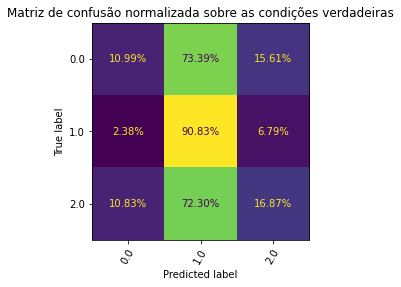

Acurácia treino:  90.67427595783661
              precision    recall  f1-score   support

         0.0      0.948     0.790     0.862     81676
         1.0      0.897     0.970     0.932    185883
         2.0      0.898     0.882     0.890     93228

    accuracy                          0.907    360787
   macro avg      0.914     0.881     0.895    360787
weighted avg      0.909     0.907     0.905    360787



In [85]:
for model in models:
    print(model)
    if(model == xgb_model):
        y_train = enc.transform(y_train.array.reshape(-1, 1))
        y_test = enc.transform(y_test.array.reshape(-1, 1))
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('Acurácia teste: ', accuracy_score(y_test, preds)*100)
    print(classification_report(y_test, preds, digits=3))
    imprimeMatrizDeConfusão(y_test, preds, model)
    preds = model.predict(X_train)
    print('Acurácia treino: ', accuracy_score(y_train, preds)*100)
    print(classification_report(y_train, preds, digits=3))    

#### Leave Height Out 10 cm

In [93]:
df_test = df[df['Altura esperada'] == 10.0]

In [95]:
df_train = df[df['Altura esperada'] != 10.0]

In [96]:
X_train = df_train[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_train = df_train.Comportamento
X_test = df_test[['X', 'Y' ,'Z', 'Season_fall', 'Season_spring', 'Season_summer', 'magn', 'sma', 'ent', 'pit', 'rol', 'icl']]
y_test = df_test.Comportamento

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1)
Acurácia teste:  54.08243846138271
              precision    recall  f1-score   support

        Ocio      0.354     0.071     0.118     40651
  Pastejando      0.599     0.870     0.709     83076
   Ruminando      0.259     0.204     0.228     24432

    accuracy                          0.541    148159
   macro avg      0.404     0.382     0.352    148159
weighted avg      0.475     0.541     0.468    148159



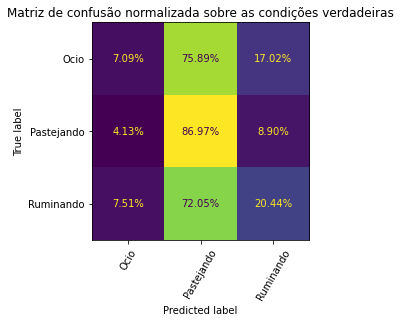

Acurácia treino:  78.71352597327616
              precision    recall  f1-score   support

        Ocio      0.742     0.433     0.547     82606
  Pastejando      0.809     0.917     0.860    249436
   Ruminando      0.755     0.762     0.758    126949

    accuracy                          0.787    458991
   macro avg      0.769     0.704     0.722    458991
weighted avg      0.782     0.787     0.776    458991

RandomForestClassifier(criterion='entropy', max_features='sqrt',
                       min_samples_leaf=2, min_samples_split=10,
                       n_estimators=200, n_jobs=-1, random_state=0)
Acurácia teste:  53.888727650699586
              precision    recall  f1-score   support

        Ocio      0.360     0.082     0.133     40651
  Pastejando      0.597     0.866     0.707     83076
   Ruminando      0.248     0.186     0.213     24432

    accuracy                          0.539    148159
   macro avg      0.402     0.378     0.351    148159
weighted avg      0.474

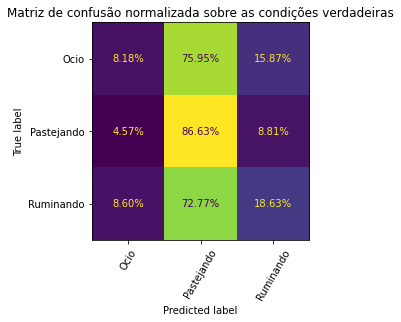

Acurácia treino:  89.39042377737255
              precision    recall  f1-score   support

        Ocio      0.927     0.703     0.799     82606
  Pastejando      0.887     0.965     0.925    249436
   Ruminando      0.892     0.878     0.885    126949

    accuracy                          0.894    458991
   macro avg      0.902     0.849     0.870    458991
weighted avg      0.896     0.894     0.891    458991

KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance')
Acurácia teste:  48.80634993486727
              precision    recall  f1-score   support

        Ocio      0.346     0.125     0.183     40651
  Pastejando      0.586     0.750     0.658     83076
   Ruminando      0.181     0.201     0.191     24432

    accuracy                          0.488    148159
   macro avg      0.371     0.359     0.344    148159
weighted avg      0.453     0.488     0.451    148159



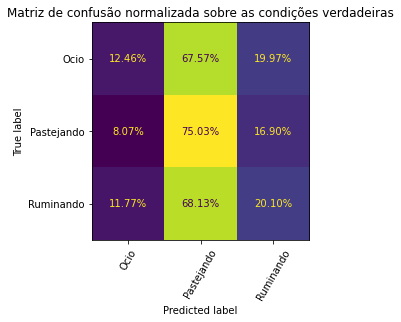

Acurácia treino:  99.98714571745415
              precision    recall  f1-score   support

        Ocio      0.999     1.000     1.000     82606
  Pastejando      1.000     1.000     1.000    249436
   Ruminando      1.000     1.000     1.000    126949

    accuracy                          1.000    458991
   macro avg      1.000     1.000     1.000    458991
weighted avg      1.000     1.000     1.000    458991

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_delta_step=None, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=-1, num_parallel_tree=None,
              predictor=None, random_state=0, reg_alpha=None, reg_lambda=None,
              scale_po

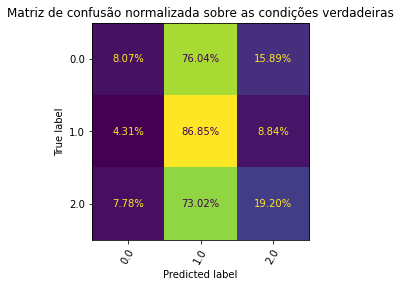

Acurácia treino:  91.15058900937055
              precision    recall  f1-score   support

         0.0      0.937     0.735     0.824     82606
         1.0      0.915     0.967     0.940    249436
         2.0      0.893     0.917     0.905    126949

    accuracy                          0.912    458991
   macro avg      0.915     0.873     0.889    458991
weighted avg      0.913     0.912     0.909    458991



In [99]:
for model in models:
    print(model)
    if(model == xgb_model):
        y_train = enc.transform(y_train.array.reshape(-1, 1))
        y_test = enc.transform(y_test.array.reshape(-1, 1))
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('Acurácia teste: ', accuracy_score(y_test, preds)*100)
    print(classification_report(y_test, preds, digits=3))
    imprimeMatrizDeConfusão(y_test, preds, model)
    preds = model.predict(X_train)
    print('Acurácia treino: ', accuracy_score(y_train, preds)*100)
    print(classification_report(y_train, preds, digits=3))    

#### Leave One Animal Out

In [123]:
from sklearn.model_selection import cross_val_score

In [179]:
def executarLogo(models, groups, X, y):
    for score in ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted']:
        logo = LeaveOneGroupOut()
        for model in models:
            print(model)
            if(model == xgb_model):
                y = enc.transform(y.array.reshape(-1, 1))
            cv = logo.split(X, y, groups)
            cvs = cross_val_score(model, X, y, scoring=score, cv=cv, n_jobs=-1).mean()
            print(score + " : "+ str(cvs)) 
        print('\n')

In [180]:
groups = np.array(df.Animal.values)
models = [lgb_model, knn_model, xgb_model]

In [ ]:
executarLogo(models, groups, X, y)

LGBMClassifier(colsample_bytree=0.662, min_child_samples=1, num_leaves=512,
               random_state=0, subsample_freq=1)
accuracy : 0.5248896328774799
KNeighborsClassifier(leaf_size=20, n_jobs=-1, n_neighbors=37, p=1,
                     weights='distance')
accuracy : 0.5129596076570876
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5370264280766771,
              enable_categorical=False, gamma=0.0, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=16,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=-1, num_parallel_tree=1,
              objective='multi:softprob', predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_pa